<center> <h1>Probabilistic Loan Pricing</h1> </center>
<center> <h4>Erick Daniel Rodríguez Villafuerte</h4> </center>

- [**Overview**](#Overview): Brief description of the problem and the model
- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Default Probability**](#Default-Probability): Function to determine the risk of default by year
- [**IRR**](#Internal-Rate-of-Return): Defines IRR and starts model
- [**Outputs**](#Outputs): Shows the final output for the model

## Overview

### Problem Definition
<div style="text-align: justify"> You work for a bank who is considering loaning funds to a small manufacturing business. The business needs
$price_{machine}$ to buy machinery. The business would like to borrow the funds for $n_{life}$, and at that time it will repay $price_{machine}$ in full. Interest is paid annually at a rate of $r_{interest}$ (in the final period, both $price_{machine}$ and interest at the rate of $r_{interest}$ will be paid). As this is a small business, there is significant default risk, but that default risk decreases over time as the business matures.The probability of default in the first year is $p_1^{default}$ , and then each year thereafter it is:
    $$p_t^{default} = p_{t-1}^{default} Decay_{default}$$ <br>

<div style="text-align: justify"> Finally, the default probability is different in the final year, as it is the repayment year. The business has to pay a lot more in this period so there is a greater likelihood it can’t come up with the funds. In the final year, (at default year $n_{life}$), the default probability is $p_n^{default}$ . 
<br><br>
<div style="text-align: justify"> When the business defaults, then the default covenants of the loan trigger bankruptcy for the borrower, and the borrower must pay as much as it can on the loan in the bankruptcy process. The bankruptcy process takes two years, and then once it is resolved, the lender will collect $r_{recovery}$% of $price_{machine}$. For the year of default and the year after, the lender will not collect any cash flows, and then two years after default, the lender will collect $r_{recovery}price_{machine}$. Note that this means the number of years of cash flows may be up to two years greater than the life of the loan.

### Main Question
<div style="text-align: justify">You are the commercial loan analyst trying to decide if this loan makes sense for the bank. You want to give the lending officer all the information she would need to negotiate a rate for this loan.
    
> Given the inputs, what is the expected IRR of the loan for a variety of interest rates on the loan?

- <div style="text-align: justify">The lending officer would like you to evaluate rates in 5% increments from 30% to 40%.
- <div style="text-align: justify">The lending officer is also worried that she may have estimated $p_1^{default}$ incorrectly. She is hoping for the answers to the above questions considering that $p_1^{default}$ may vary. Evaluate the above questions for $p_1^{default}$ = 0.1,0.3 in addition to the base case of 0.2.
- <div style="text-align: justify">Finally, the lending officer is unsure for how long she should extend the loan. So she would like to see all of the previously mentioned results with loan lifes of 5, 10, and 20 years. 
<div> 

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import numpy_financial as npf
import random
import itertools
%matplotlib inline

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    price_machine: float = 1000000
    loan_life: int = 5
    initial_default: float = 0.2
    default_decay: float = 0.9
    final_default: float = 0.4
    recovery_rate: float = 0.4
    interest: float = 0.2
    num_iterations: int = 1000
        
model_data = ModelInputs()
model_data

ModelInputs(price_machine=1000000, loan_life=5, initial_default=0.2, default_decay=0.9, final_default=0.4, recovery_rate=0.4, interest=0.2, num_iterations=1000)

## Default Probability
There is an initial default probability $P_t^{default}$, as the years pass-by, the risk of the company to default goes lower by $Decay_{default}$. This is valid until the last year where the probability of default is $P_n^{default}$

Loan can be for a maximum of 20 years, if a greater number is given, it will max out at 20.

In [3]:
def default_prob_by_year(data: ModelInputs, p1_default = ModelInputs.initial_default, years = ModelInputs.loan_life):  
    '''
    Creates a list of probability of default by year, number of years is
    set to the initial input of "loan_life", you could set a different 
    number of years, however, it will max at 20 years
    '''
    # n_years starts at year 2 since the first year is defined in the problem
    n_years = list(range(2, years))
    expected_default_list = [p1_default]
    if years <= 20:
        for year in n_years:
            expected_default = expected_default_list[-1] * data.default_decay
            expected_default_list.append(expected_default)
    elif years > 20:
        # same idea as n_years, i will start in 2
        i = 2
        while i < 20:
            expected_default = expected_default_list[-1] * data.default_decay
            expected_default_list.append(expected_default)
            i += 1
    expected_default_list.append(data.final_default)
    return expected_default_list
# Even if the input is set to n-years, it will only consider a maximum of 20 years
# Note that this restriction is specifically for the given model, could be changed to accept longer credit periods

Now that we generated a list of default probabilities by year, we proceed to get the probability of repayment by year, which will be just $1 - p_n^{default}$ . 

In [4]:
def repayment_prob_by_year(prob_list):
    '''
    Given a list of probability of default per year, calculates
    the probability of non-default
    '''
    repayment_prob_list = []
    for i in prob_list:
        rep_prob = 1 - i
        repayment_prob_list.append(rep_prob)
    return repayment_prob_list

## Internal Rate of Return

The internal rate of return is a metric used in financial analysis to estimate the profitability of potential investments. The internal rate of return is a discount rate that makes the net present value (NPV) of all cash flows equal to zero in a discounted cash flow analysis. 


$$0 = NPV = \sum_{t=1}^T \frac{C_t}{(1 + IRR)^t} - C_0$$
**Where**:
- $C_t$ = Net cash inflow during the period
- $C_0$ = Total Initial investment costs
- $IRR$ = The internal rate of return
- $t$ = The number of time periods

Generally speaking, the higher an internal rate of return, the more desirable an investment is to undertake.

In [5]:
def get_cash_flows(data: ModelInputs, repayment_prob, default_prob, rate = ModelInputs.interest):
    '''
    This function generates the cash flows for the model, taking into account
    the bankruptcy triggers for the bank
    '''
    cash_flows = [-data.price_machine]
    bankruptcy = 0, 0, data.price_machine * data.recovery_rate
    interest = rate * data.price_machine
    for i in range(len(repayment_prob)):
        repayment_or_default = random.choices(['Repayment', 'Default'], [repayment_prob[i], default_prob[i]])[0]
        if repayment_or_default == 'Repayment':
            cash_flows.append(interest)
        else:
            cash_flows.extend(bankruptcy)
            break
    if cash_flows[-1] == interest and len(cash_flows) == len(repayment_prob)+1:
        cash_flows[-1] = cash_flows[-1] + data.price_machine
    return cash_flows

In [6]:
def full_loan_pricing(data: ModelInputs, rate, years, p1_default, print_cash_flows=False):
    '''
    Serves as a final function, runs all the previous functions in order
    to get the IRR given an intial default probability, number of years
    and an interest rate
    '''
    def_list = default_prob_by_year(data, p1_default, years)
    rep_list = repayment_prob_by_year(def_list)
    cash_flows = get_cash_flows(data, rep_list, def_list, rate)
    # If input is set to True, it will print the cash flows in order to see when 
    # the company defaulted
    if print_cash_flows:
        print(cash_flows)
        try:
            print(f'\nCompany defaulted at year: {[i for i,x in enumerate(cash_flows) if x == 0][0]}\nThe IRR is:')
        except:
            print('\nCompany did not default \nThe IRR is:')
    return npf.irr(cash_flows)

We can run the function to see an example.

In [7]:
full_loan_pricing(model_data, .2, 10, .1, True)

[-1000000, 200000.0, 200000.0, 200000.0, 200000.0, 200000.0, 200000.0, 200000.0, 200000.0, 200000.0, 1200000.0]

Company did not default 
The IRR is:


0.20000000000000018

In [8]:
def get_irr(data: ModelInputs, rate_list, years_list, def_prob_list, iterations = ModelInputs.num_iterations):
    '''
    Creates a list of the IRR's for the given list of inputs 
    '''
    tup_list =  [[(x,y,z) for y in years_list for z in def_prob_list]for x in rate_list]
    model_tup_list = [[(model_data,x,y,z) for y in years_list for z in def_prob_list]for x in rate_list]
    model_list = [t for lst in model_tup_list for t in lst]

    lst = []
    for i in range(iterations):
        lst_lst = []
        for i in model_list:
            lst_lst.append(full_loan_pricing(*i))
        lst.append(lst_lst)
    # 
    arrays = [np.array(x) for x in lst]
    irr_lst = [np.mean(k) for k in zip(*arrays)]
    return irr_lst

## Outputs

In [9]:
# Inputs for the model
rates =[0.3, 0.35, 0.4]
years =[5, 10, 20]
p_1= [0.1, 0.2, 0.3]

,Interest Rate,Loan Life,Initial Default Probability,IRR
0,30.00%,5,10.00%,13.43%
1,30.00%,5,20.00%,5.00%
2,30.00%,5,30.00%,-2.73%
3,30.00%,10,10.00%,15.74%
4,30.00%,10,20.00%,5.31%
5,30.00%,10,30.00%,-1.82%
6,30.00%,20,10.00%,15.47%
7,30.00%,20,20.00%,5.73%
8,30.00%,20,30.00%,-3.03%
9,35.00%,5,10.00%,17.63%


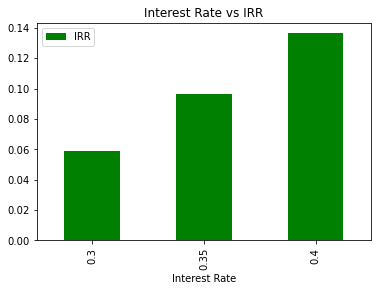

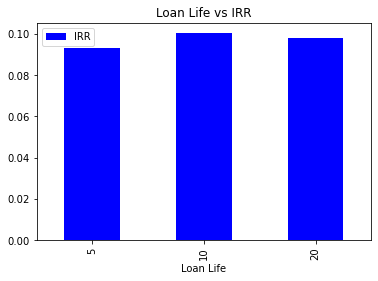

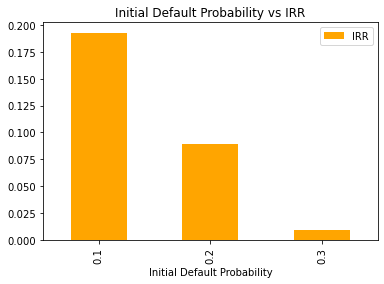

In [58]:
def df_irr(data: ModelInputs, rate_list, years_list, def_prob_list):
    '''
    Creates a dataframe with the different IRR's for the given inputs
    '''
    tup_list =  [[(x,y,z) for y in years_list for z in def_prob_list]for x in rate_list]
    irr_df = pd.DataFrame([t for lst in tup_list for t in lst],
                      columns=['Interest Rate',
                               'Loan Life',
                               'Initial Default Probability'])
    irr_df['IRR'] = get_irr(data, rates, years, p_1)
    return irr_df

def formatted_df_irr(data: ModelInputs, rate_list, years_list, def_prob_list):
    '''
    Adds format to the different columns
    '''
    df = df_irr(data, rate_list, years_list, def_prob_list)
    df = df.style.background_gradient(cmap ='RdYlGn', subset='IRR').format({
        'Interest Rate': '{:,.2%}',
        'Initial Default Probability': '{:,.2%}',
        'IRR': '{:,.2%}'
    })
    return df

def formatted_and_display(data: ModelInputs, rate_list, years_list, def_prob_list):
    '''
    Shows plot and formatted DataFrame
    '''
    df = df_irr(data, rate_list, years_list, def_prob_list)
    colors = ['green', 'blue', 'orange']
    for col_name, color in zip(df.columns, colors):
        if col_name != 'IRR':
            df.groupby(col_name).mean().reset_index().plot.bar(x = col_name,
                                                               y = 'IRR',
                                                               title = f'{col_name} vs IRR',
                                                               color = color)
        else:
            break
    df_formatted = formatted_df_irr(data, rate_list, years_list, def_prob_list)
    return df_formatted

formatted_and_display(model_data, rates, years, p_1)

With the formatted DataFrame we can take a look at which combinations work better for the IRR. <br><br>
The plots show an average of IRR for the different scenarios, interesting to see that:
- Loan Life has not such a great impact on the IRR
- The greater the Interest Rate the greater then IRR
- The lower Initial Default Probability is, the higher the IRR

`Initial Default Probabilit` carries a huge impact on the IRR, generatting another model to determine `Initial Probability Default` could be quite helpful, another idea could be to assume that it has a normal distribuition with a given mean and standard deviation and apply Monte Carlo Simulation to it. Mean and Standard deviation could be based on several assumptions:
- Company's credit history.
- If company is new, perhaps look at similar companies to determine an initial default probability.
- Forecasting future cash flows of the company.

---

[**Back to Top**](#Probabilistic-Loan-Pricing)